# Arriving Passenger Darts Modeling

by yuki (initialized 7/19)

## Installing Darts

In [3]:
!pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 400 kB 7.3 MB/s 
     |████████████████████████████████| 1.4 MB 47.5 MB/s 
     |████████████████████████████████| 585 kB 54.0 MB/s 
     |████████████████████████████████| 179 kB 58.7 MB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 
     |████████████████████████████████| 9.8 MB 34.3 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 793 kB 48.9 MB/s 
     |████████████████████████████████| 11.2 MB 37.7 MB/s 
     |████████████████████████████████| 381 kB 56.6 MB/s 
     |████████████████████████████████| 944 kB 48.6 MB/s 
     |████████████████████████████████| 140 kB 50.6 MB/s 
     |████████████████████████████████| 596 kB 42.5 MB/s 
     |████████████████████████████████| 419 kB 53.8 MB/s 
     |████████████████████████████████| 1.1 MB 41.7 MB/s 
     |█████████████████████████████

In [4]:
!pip install pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 636 kB 6.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


In [5]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 9.1 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nfoursid 1.0.1 requires matplotlib>=3.3, but you have matplotlib 3.1.3 which is incompatible.
darts 0.20.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [6]:
!pip install sodapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    AutoARIMA,
    VARIMA,
    ExponentialSmoothing,
    Theta
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.utils.utils import SeasonalityMode

import sklearn
from sklearn.metrics import r2_score

from sodapy import Socrata


## Checking Dataframe

In [145]:
df = pd.read_csv('ArrPaxFinaldf.csv')

In [146]:
pd.set_option('display.max_columns', None)

In [147]:
df.head()

,TimeInterval,Season,AT_PAX,Taxi_PAX,Weather,Parking#,FHV#,holiday,total_doses,pax_intl_bus,pax_intl_lei,pax_dom_bus,pax_dom_lei
0,2021-03-13 00:00:00,2,3.166667,0.0,1.0,5.333333,1.333333,0,118109283,0.0,0.0,0.0,0.0
1,2021-03-13 00:10:00,2,3.166667,0.0,1.0,5.333333,1.333333,0,118109283,0.0,0.0,0.0,0.0
2,2021-03-13 00:20:00,2,3.166667,0.0,1.0,5.333333,1.333333,0,118109283,0.0,0.0,0.0,0.0
3,2021-03-13 00:30:00,2,3.166667,0.0,1.0,5.333333,1.333333,0,118109283,0.0,0.0,0.0,0.0
4,2021-03-13 00:40:00,2,3.166667,0.0,1.0,5.333333,1.333333,0,118109283,0.0,0.0,0.0,0.0


In [148]:
df['TimeInterval'] = pd.to_datetime(df['TimeInterval'])
df.set_index('TimeInterval',inplace=True)

In [149]:
df = df.asfreq('10T')
df.index = pd.to_datetime(df.index)
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [150]:
df.describe()

,Season,AT_PAX,Taxi_PAX,Weather,Parking#,FHV#,holiday,total_doses,pax_intl_bus,pax_intl_lei,pax_dom_bus,pax_dom_lei
count,42336.000000,42336.000000,42336.000000,42336.000000,42330.000000,42336.000000,42336.000000,4.233600e+04,42336.000000,42336.000000,42336.000000,42336.000000
mean,2.826531,23.988473,0.254614,1.298469,44.446208,8.710672,0.139456,3.586837e+08,2.229939,16.656107,11.118897,34.519480
std,0.986576,20.025184,0.366851,0.655248,22.063763,7.530635,0.346426,1.010667e+08,8.800598,63.064756,24.464704,73.953926
min,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.181093e+08,0.000000,0.000000,0.000000,0.000000
25%,2.000000,9.333333,0.000000,1.000000,27.666667,1.500000,0.000000,3.045942e+08,0.000000,0.000000,0.000000,0.000000
50%,3.000000,20.333333,0.000000,1.000000,46.333333,7.833333,0.000000,3.681045e+08,0.000000,0.000000,0.000000,0.000000
75%,4.000000,33.166667,0.333333,1.000000,60.666667,13.333333,0.000000,4.290358e+08,0.000000,0.000000,0.000000,0.000000
max,4.000000,154.333333,3.000000,4.000000,113.500000,43.166667,1.000000,5.306513e+08,148.217185,1096.071415,232.992257,589.333357


In [151]:
df['Parking#'].fillna(0,inplace=True)

## Add COVID variables for training

In [152]:
client = Socrata("health.data.ny.gov", None)
results = client.get("ksjn-24s4",limit=50000)
vax = pd.DataFrame.from_records(results).rename({'report_as_of':'date'},axis=1)
vax['date'] = vax.date.str[:10]
vax['first_dose_ct'] = pd.to_numeric(vax['first_dose_ct'])
vax['series_complete_cnt'] = pd.to_numeric(vax['series_complete_cnt'])
vax = vax[['first_dose_ct', 'series_complete_cnt', 'date']].groupby('date',as_index=False).sum()
vax.head()

2022-07-22 14:50:23 root WARNING: Requests made without an app_token will be subject to strict throttling limits.


,date,first_dose_ct,series_complete_cnt
0,2020-12-14,201,0
1,2020-12-15,1589,3
2,2020-12-16,6579,16
3,2020-12-17,12660,34
4,2020-12-18,21186,60


In [153]:
# get the most recent NYC covid case counts, hospitalizations, deaths
covid = pd.read_json('https://data.cityofnewyork.us/resource/rc75-m7u3.json')
covid = covid[['date_of_interest','case_count_7day_avg','hosp_count_7day_avg','death_count_7day_avg']].rename({'date_of_interest':'date'},axis=1)
covid['date'] = covid.date.str[:10]
covid.head()

,date,case_count_7day_avg,hosp_count_7day_avg,death_count_7day_avg
0,2020-02-29,0,0,0
1,2020-03-01,0,0,0
2,2020-03-02,0,0,0
3,2020-03-03,0,0,0
4,2020-03-04,0,0,0


In [154]:
from sklearn.preprocessing import StandardScaler

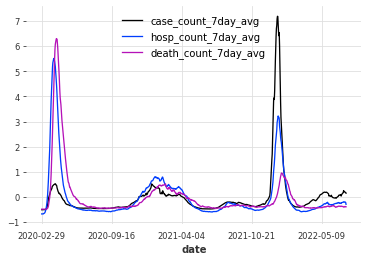

In [155]:
# turns out this data messes up the model performance because of the omicron surge in December 2021. The surge was bigger than anything the model saw during training,
# so it didn't know how to react and gave bad predictions. The vaccination data is still helpful for the model, but we will exclude these variables.
# When retraining the model in the future with more training data, consider including these variables.
pd.DataFrame(StandardScaler().fit_transform(covid[['case_count_7day_avg','hosp_count_7day_avg',
       'death_count_7day_avg']]),columns = ['case_count_7day_avg','hosp_count_7day_avg',
       'death_count_7day_avg'],index=covid['date']).plot()

In [156]:
df = df.reset_index()
df['Date'] = df['TimeInterval'].astype(str).str[:10]

In [157]:
df = pd.merge(df, vax, how= 'left', left_on = 'Date', right_on = 'date')
# df = pd.merge(df, covid[['date','death_count_7day_avg']], how= 'left', left_on = 'Date', right_on = 'date')

In [158]:
df.isna().sum()

TimeInterval           0
Season                 0
AT_PAX                 0
Taxi_PAX               0
Weather                0
Parking#               0
FHV#                   0
holiday                0
total_doses            0
pax_intl_bus           0
pax_intl_lei           0
pax_dom_bus            0
pax_dom_lei            0
Date                   0
date                   0
first_dose_ct          0
series_complete_cnt    0
dtype: int64

In [159]:
# df = df.drop(['Date', 'date_x','date_y', 'total_doses'],axis=1)
df = df.drop(['Date', 'date', 'total_doses'],axis=1)
df = df.set_index('TimeInterval')
df.head()

,Season,AT_PAX,Taxi_PAX,Weather,Parking#,FHV#,holiday,pax_intl_bus,pax_intl_lei,pax_dom_bus,pax_dom_lei,first_dose_ct,series_complete_cnt
TimeInterval,,,,,,,,,,,,,
2021-03-13 00:00:00,2,3.166667,0.0,1.0,5.333333,1.333333,0,0.0,0.0,0.0,0.0,4172547,2171067
2021-03-13 00:10:00,2,3.166667,0.0,1.0,5.333333,1.333333,0,0.0,0.0,0.0,0.0,4172547,2171067
2021-03-13 00:20:00,2,3.166667,0.0,1.0,5.333333,1.333333,0,0.0,0.0,0.0,0.0,4172547,2171067
2021-03-13 00:30:00,2,3.166667,0.0,1.0,5.333333,1.333333,0,0.0,0.0,0.0,0.0,4172547,2171067
2021-03-13 00:40:00,2,3.166667,0.0,1.0,5.333333,1.333333,0,0.0,0.0,0.0,0.0,4172547,2171067


## Splitting and Scaling

In [160]:
covariates = df[df.columns[~df.columns.isin(['AT_PAX','Taxi_PAX','Parking#','FHV#'])]]
targets = df[['AT_PAX','Parking#','FHV#']]

In [161]:
cov = TimeSeries.from_dataframe(covariates,freq='10T')
tar = TimeSeries.from_dataframe(targets,freq='10T')

In [162]:
#scaling

sc_cov = Scaler()
cov_sc = sc_cov.fit_transform(cov)

sc_tar = Scaler()
tar_sc = sc_tar.fit_transform(tar)

In [163]:
cov_train, cov_test = cov_sc.split_before(pd.Timestamp(2021,12,1))
tar_train, tar_test = tar_sc.split_before(pd.Timestamp(2021,12,1))

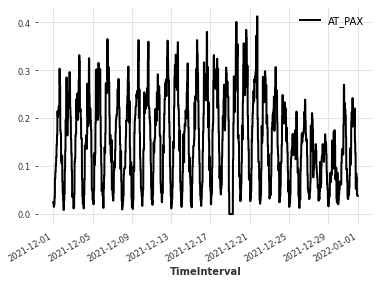

In [164]:
tar_test['AT_PAX'].plot()

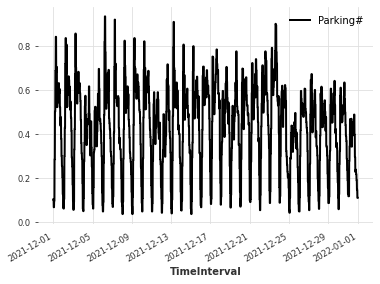

In [165]:
tar_test['Parking#'].plot()

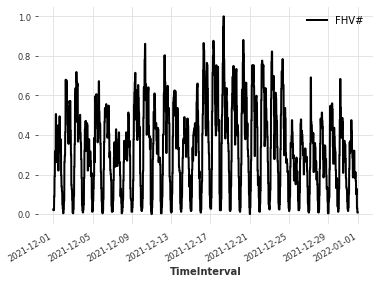

In [166]:
tar_test['FHV#'].plot()

## Model Fitting RNN/LSTM

In [ ]:
len(tar_train)+len(cov_test)

In [ ]:
from darts.utils.likelihood_models import LaplaceLikelihood

In [ ]:
my_model = RNNModel(
    model="LSTM",
    n_epochs=10,
    model_name="Arr_RNN",
    training_length=32,
    input_chunk_length=144,
    output_chunk_length=6,
    hidden_dim = 25,
    n_rnn_layers=4,
    optimizer_kwargs={'lr':.05},
    random_state=42,
    likelihood=LaplaceLikelihood(prior_b=0.01),
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "auto_select_gpus":True
    }
)

In [ ]:
my_model.fit(
    series=tar_train,
    future_covariates= cov_sc,
    verbose=True,
)

In [ ]:
len(tar_train)

In [ ]:
pred = my_model.predict(n=4450,future_covariates=cov_sc)
print(r2_score(tar_test[:4450].pd_dataframe(),pred.pd_dataframe()))

In [ ]:
pred['AT_PAX'][:800].plot()
tar_test['AT_PAX'][:800].plot()

In [ ]:
print(r2_score(tar_test[:3000].pd_dataframe(),pred.pd_dataframe())) 

In [ ]:
pred['AT_PAX'][:300].plot()
tar_test['AT_PAX'][:300].plot()

In [ ]:
pred['AT_PAX'][:300].plot()
tar_test['AT_PAX'][:300].plot()

In [ ]:
pred['Taxi_PAX'][:300].plot()
tar_test['Taxi_PAX'][:300].plot()

In [ ]:
pred['Parking#'][:300].plot()
tar_test['Parking#'][:300].plot()

In [ ]:
pred['FHV#'][:300].plot()
tar_test['FHV#'][:300].plot()

## Darts Regression

In [30]:
from darts.models import RegressionModel

In [167]:
regr_model = RegressionModel(lags=None,
                           #   lags_past_covariates=[-5, -4, -3, -2, -1], 
                             lags_future_covariates = (4,30))

regr_model.fit(tar_train ,
            #    past_covariates=melting,
               future_covariates=cov_sc)

In [168]:
pred = regr_model.predict(n=4434,future_covariates=cov_sc)

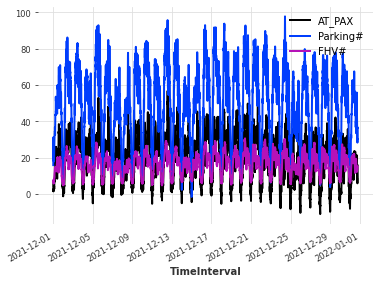

In [169]:
sc_tar.inverse_transform(pred).plot()

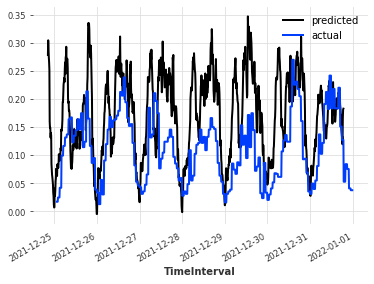

In [96]:
pred['AT_PAX'][-1000:].plot(label='predicted')
tar_test['AT_PAX'][-1000:].plot(label = 'actual')

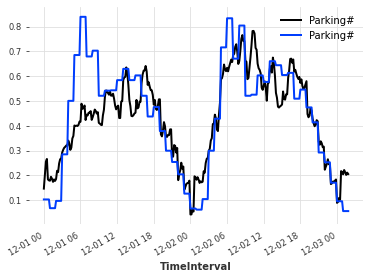

In [123]:
pred['Parking#'][:300].plot()
tar_test['Parking#'][:300].plot()

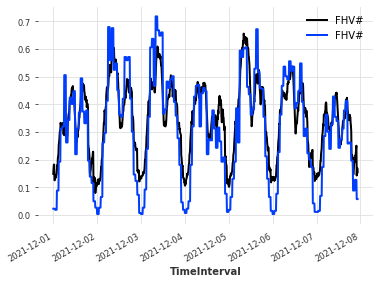

In [119]:
pred['FHV#'][:1000].plot()
tar_test['FHV#'][:1000].plot()

In [172]:
print(r2_score(tar_test[:4434].pd_dataframe(),pred.pd_dataframe())) 

0.5701318370066197


In [102]:
def plot_agg_result(actual, pred,frequency,start_date,end_date):

    test_df = actual.pd_dataframe()
    test_df = pd.merge(test_df, pred.pd_dataframe(), how='right',left_index=True, right_index=True)

    
    test_df = test_df.reset_index()
    test_df = test_df.groupby(pd.Grouper(key="TimeInterval", freq=frequency)).sum()

    s_date = pd.to_datetime(start_date)
    e_date = pd.to_datetime(end_date)

    print(r2_score(test_df.iloc[:,0],test_df.iloc[:,1]))
    test_df.loc[(test_df.index >= s_date) & (test_df.index <= e_date),:].plot()

0.473954721195319


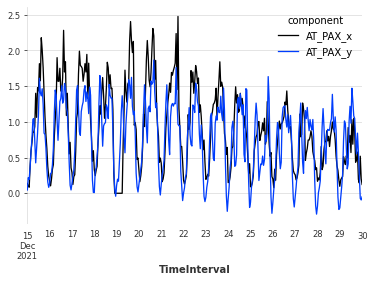

In [139]:
plot_agg_result(tar_test['AT_PAX'],pred['AT_PAX'],'1H','2021-12-15','2021-12-30')

0.7158350698328383


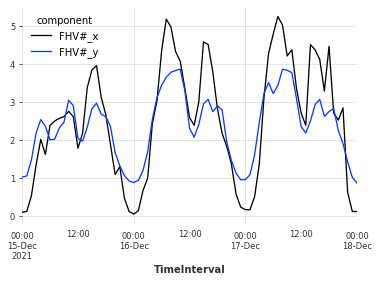

In [140]:
plot_agg_result(tar_test['FHV#'],pred['FHV#'],'1H','2021-12-15','2021-12-18')

0.5919921484505992


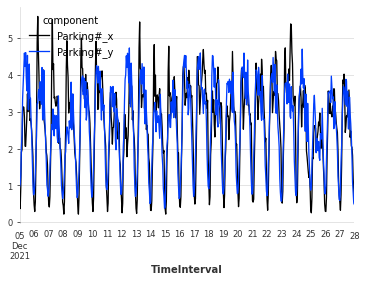

In [144]:
plot_agg_result(tar_test['Parking#'],pred['Parking#'],'1H','2021-12-05','2021-12-28')

In [173]:
import joblib
joblib.dump(regr_model,'arrpax_regr.pkl')

['arrpax_regr.pkl']